### Q1. Local Binary Pattern (LBP) for Texture Analysis

In [ ]:
import numpy as np
import skimage
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob
from skimage.transform import rotate

In [2]:
dataset_path = '../DTD_dataset'
train_path = dataset_path + '/train'
test_path = dataset_path + '/test'

In [3]:
def calculate_lbp_histogram_from_lbp_map(lbp_map):
  lbp_hist = np.histogram(lbp_map, bins=256, range=(0,256))[0]
  total_pixels = np.sum(lbp_hist)
  return lbp_hist / total_pixels

#### LBP without vectorization

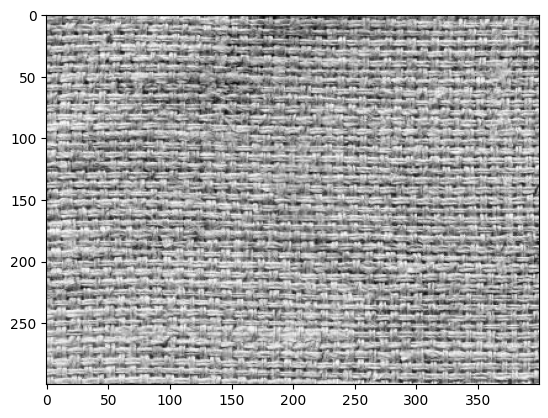

In [37]:
img = skimage.io.imread(train_path + '/woven/01797.png')
img = img.astype(np.float32) / 255.0
img = skimage.color.rgb2gray(img)
plt.imshow(img, cmap='gray')

In [5]:
img = np.round(img * 255).clip(0, 255).astype(np.uint8)

In [6]:
# this function will take the 3x3 neighborhood (as 1d array) of the pixel and give us the lbp code (0-255)
def calculate_lbp_code_for_pixel(neighborhood):
  if len(neighborhood) != 9:
    raise Exception("Neighborhood should be of size 9")

  central_pixel_value = neighborhood[4]
  lbp_code = 0
  neighbor_indices = [1, 2, 4, 128, None, 8, 64, 32, 16]

  for i in range(9):
    if i == 4:
      continue
    if neighborhood[i] >= central_pixel_value:
      lbp_code += neighbor_indices[i]

  # print(f"lbp_code:{lbp_code}")

  return lbp_code

In [7]:
def get_lbp_map_for_img(img):
  lbp_map = scipy.ndimage.generic_filter(img, calculate_lbp_code_for_pixel, size=3, mode='mirror').astype(np.uint8)
  return lbp_map

In [8]:
lbp_map = get_lbp_map_for_img(img)
print(lbp_map)

[[221   0 227 ... 127 107  85]
 [255  34 193 ... 128 128 143]
 [253 112 243 ... 231 223   7]
 ...
 [  2 157   0 ...   0 200   0]
 [143 159   2 ...  51 247 255]
 [119 255  34 ...   8   0 136]]


In [9]:
lbp_hist = calculate_lbp_histogram_from_lbp_map(lbp_map)

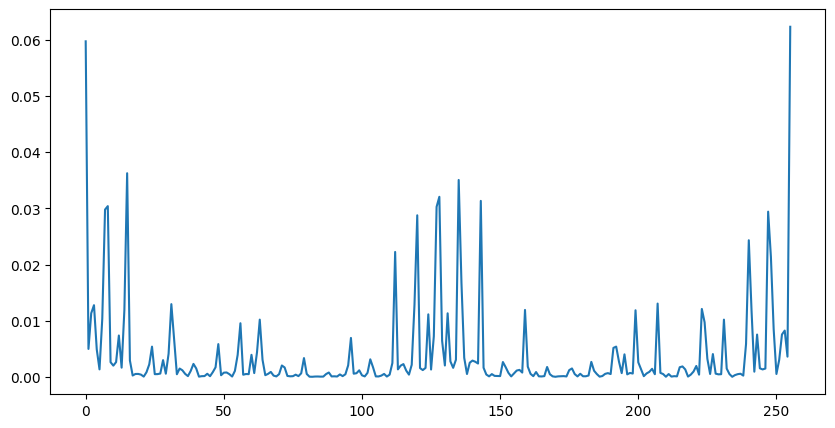

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(lbp_hist)
plt.show()

#### LBP with vectorization

In [ ]:
# img = skimage.io.imread(train_path + '/woven/01797.png')
# img = img.astype(np.float32) / 255.0
# img = skimage.color.rgb2gray(img)
# plt.imshow(img, cmap='gray')

In [ ]:
# img = np.round(img * 255).clip(0, 255).astype(np.uint8)

In [11]:
def get_lbp_map_for_img_vectorized(img):
  # 1. create the 8 shifted arrays

  # the top array will contain the top element of each element.
  # for example if top element of arr[1,1] = 12 then top[1,1] = 12

  padded_img = np.pad(img, pad_width=1, mode='reflect')

  top = padded_img[:-2, 1:-1]
  bottom = padded_img[2:, 1:-1]
  left = padded_img[1:-1, :-2]
  right = padded_img[1:-1, 2:]

  top_left = padded_img[:-2, :-2]
  top_right = padded_img[:-2, 2:]
  bottom_left = padded_img[2:, :-2]
  bottom_right = padded_img[2:, 2:]

  #  2. Calculate the lbp map (0-255) for the whole image
  lbp_map = (top_left >= img)*1 + (top >= img)*2 + (top_right >= img)*4 + (right >= img)*8 + (bottom_right >= img)*16 + (bottom >= img)*32 + (bottom_left >= img)*64 + (left >= img)*128
  return lbp_map

In [12]:
lbp_map_vectorized = get_lbp_map_for_img_vectorized(img)
# print(lbp_map_vectorized)

In [13]:
lbp_hist_vectorized = calculate_lbp_histogram_from_lbp_map(lbp_map_vectorized)

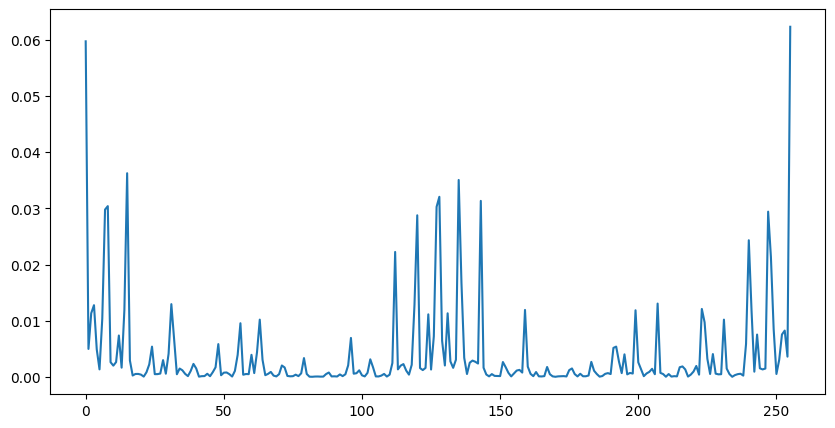

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(lbp_hist_vectorized)
plt.show()

In [ ]:
#TODO: instead of creating np.zeros, we can create one padded version, then do slicing. - DONE

# top = np.zeros(arr2.shape).astype(np.uint8)
# top[1:, :] = arr2[:-1, :]
# print(top)

# bottom = np.zeros(arr2.shape).astype(np.uint)
# bottom[:-1, :] = arr2[1:, :]
# print(bottom)

# right = np.zeros(arr2.shape).astype(np.uint8)
# right[:, :-1] = arr2[:, 1:]
# print(right)

# left = np.zeros(arr2.shape).astype(np.uint8)
# left[:, 1:] = arr2[:, :-1]
# print(left)

# top_left = np.zeros(arr2.shape).astype(np.uint8)
# top_left[1:, 1:] = arr2[:-1, :-1]
# print(top_left)

# top_right = np.zeros(arr2.shape).astype(np.uint8)
# top_right[1:, :-1] = arr2[:-1, 1:]
# print(top_right)

# bottom_left = np.zeros(arr2.shape).astype(np.uint8)
# bottom_left[:-1, 1:] = arr2[1:, :-1]
# print(bottom_left)

# bottom_right = np.zeros(arr2.shape).astype(np.uint8)
# bottom_right[:-1, :-1] = arr2[1:, 1:]
# print(bottom_right)

[[ 0  0  0]
 [ 2 12  3]
 [ 7  8  9]]
[[ 7  8  9]
 [ 8 24 14]
 [ 0  0  0]]
[[12  3  0]
 [ 8  9  0]
 [24 14  0]]
[[ 0  2 12]
 [ 0  7  8]
 [ 0  8 24]]


#### Training on the complete dataset

In [ ]:
# Logic:
# traverse the train directory, class by class.
# for a particular class:
#   for each image:
#     compute the histogram and add it to the list feature_vectors_train, also add the class name to the class_labels list.
#     the ith element of the feature_vectors_train will contain the histogram of ith image.
#     the ith element of the class_lables will contain the class of the ith image.
# convert the feature_vectors_train list to numpy array

In [ ]:
def compute_lbp_hist_for_img_path(img_path):
  img = skimage.io.imread(img_path)
  img = img.astype(np.float32) / 255.0
  img = skimage.color.rgb2gray(img)
  img = np.round(img * 255).clip(0, 255).astype(np.uint8)

  # compute lbp
  lbp_map = get_lbp_map_for_img_vectorized(img)
  lbp_hist = calculate_lbp_histogram_from_lbp_map(lbp_map)
  return lbp_hist

In [45]:
x_train = [] # will contain the histograms
y_train = [] # will contain the classes


train_dirs = [x for x in Path(train_path).iterdir()]
print(f"Total sub-directories found in train directory: {len(train_dirs)}")
print('___________________________\n')

# Traverse each sub-directory (class)
total_images = 0
for train_subdir in train_dirs:
  class_name = os.path.basename(train_subdir)
  print(f"Started processing class: {class_name}")

  # Get all image paths for that class
  img_paths = sorted(glob.glob(os.path.join(train_subdir, '*.png')))
  print(f"Total images found for class - {class_name}: {len(img_paths)}\n")

  # process each image
  for img_path in img_paths:
    print(f"Processing image: {os.path.basename(img_path)}")
    lbp_hist = compute_lbp_hist_for_img_path(img_path)
    x_train.append(lbp_hist)
    y_train.append(class_name)
    total_images += 1

  print(f"\nFinished processing class: {class_name}")
  print('___________________________\n')


print(f"Total images processed in train directory: {total_images}")

x_train_matrix = np.vstack(x_train)
y_train_np = np.array(y_train)

Total sub-directories found in train directory: 48
___________________________

Started processing class: gauzy
Total images found for class - gauzy: 40

Processing image: 00600.png
Processing image: 00601.png
Processing image: 00602.png
Processing image: 00603.png
Processing image: 00604.png
Processing image: 00605.png
Processing image: 00606.png
Processing image: 00607.png
Processing image: 00608.png
Processing image: 00609.png
Processing image: 00610.png
Processing image: 00611.png
Processing image: 00612.png
Processing image: 00613.png
Processing image: 00614.png
Processing image: 00615.png
Processing image: 00616.png
Processing image: 00617.png
Processing image: 00618.png
Processing image: 00619.png
Processing image: 00620.png
Processing image: 00621.png
Processing image: 00622.png
Processing image: 00623.png
Processing image: 00624.png
Processing image: 00625.png
Processing image: 00626.png
Processing image: 00627.png
Processing image: 00628.png
Processing image: 00629.png
Proces

In [46]:
print(x_train_matrix.shape)

(1880, 256)


In [ ]:
# for i in range(len(x_train_matrix)):
#   print(f"{x_train_matrix[i, 0]}")

In [ ]:
# print(y_train_np)

['banded' 'banded' 'banded' ... 'zigzagged' 'zigzagged' 'zigzagged']


#### Q1(a): Test

In [ ]:
# test_img = skimage.io.imread(train_path + '/blotchy/00040.png')
# test_img = skimage.color.rgb2gray(test_img)
# test_img = np.round(test_img * 255).clip(0, 255).astype(np.uint8)

# # compute lbp
# test_lbp_map = get_lbp_map_for_img_vectorized(test_img)
# test_lbp_hist = calculate_lbp_histogram_from_lbp_map(test_lbp_map)
# print(test_lbp_hist[0], test_lbp_hist[255])

0.06262096774193548 0.07278897849462365


In [ ]:
# diff_train_matrix_test_hist = x_train_matrix - test_lbp_hist
# print(diff_train_matrix_test_hist.shape)
# print(diff_train_matrix_test_hist[1])

(2, 256)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# squared_sum = np.sum(np.square(diff_train_matrix_test_hist), axis=1)
# print(squared_sum)

[0.18476329 0.        ]


In [ ]:
# predicted_label = y_train_np[np.argmin(squared_sum)]
# print(predicted_label)

blotchy


In [ ]:
# Logic:
# Loop through each folder
#   get all the image paths inside that folder
#   for each image do:
#     compute lbp histogram
#     calculate distance with the x_train_matrix
#     the minimum distance image's class is the predicted class

# count no of correct predictions
# calculate accuracy.

In [41]:
def predict_class_lable_for_lbp_hist(test_lbp_hist):
  diff_train_matrix_test_hist = x_train_matrix - test_lbp_hist
  squared_sum = np.sum(np.square(diff_train_matrix_test_hist), axis=1)
  predicted_label = y_train_np[np.argmin(squared_sum)]
  return predicted_label

In [47]:
test_dirs = [dir for dir in Path(test_path).iterdir()]
print(f"Total sub-directories found in test directory: {len(test_dirs)}")
print('___________________________\n')

total_images = 0
total_correct_classifications = 0

# Traverse each sub-directory (class)
for test_subdir in test_dirs:
  actual_class = os.path.basename(test_subdir)
  print(f"Started processing test sub-directory: {actual_class}")

  # Get all image paths for that class
  img_paths = sorted(glob.glob(os.path.join(test_subdir, '*.png')))
  print(f"Total test images found for sub-directory - {actual_class}: {len(img_paths)}\n")

  # process each image
  for img_path in img_paths:
    print(f"Processing test image: {os.path.basename(img_path)}")

    lbp_hist = compute_lbp_hist_for_img_path(img_path)
    predicted_class_label = predict_class_lable_for_lbp_hist(lbp_hist)
    print(f"Predicted class: {predicted_class_label}, Actual class: {actual_class}")

    total_images += 1
    if predicted_class_label == actual_class:
      total_correct_classifications += 1

  print(f"\nFinished processing class: {actual_class}")
  print('___________________________\n')

print(f"Total images processed in test directory: {total_images}")

Total sub-directories found in test directory: 48
___________________________

Started processing test sub-directory: gauzy
Total test images found for sub-directory - gauzy: 40

Processing test image: 00600.png
Predicted class: freckled, Actual class: gauzy
Processing test image: 00601.png
Predicted class: studded, Actual class: gauzy
Processing test image: 00602.png
Predicted class: marbled, Actual class: gauzy
Processing test image: 00603.png
Predicted class: stained, Actual class: gauzy
Processing test image: 00604.png
Predicted class: stained, Actual class: gauzy
Processing test image: 00605.png
Predicted class: gauzy, Actual class: gauzy
Processing test image: 00606.png
Predicted class: crystalline, Actual class: gauzy
Processing test image: 00607.png
Predicted class: striped, Actual class: gauzy
Processing test image: 00608.png
Predicted class: potholed, Actual class: gauzy
Processing test image: 00609.png
Predicted class: smeared, Actual class: gauzy
Processing test image: 0061

In [48]:
classification_acc = total_correct_classifications / total_images
print(f"Classification accuracy: {round(classification_acc * 100, 2)} %")

Classification accuracy: 13.3 %


#### Q1(b): Experimentation with image rotation

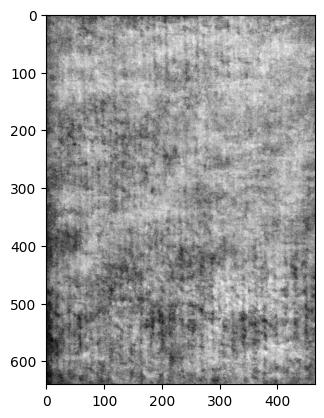

In [ ]:
# test_img = skimage.io.imread(train_path + '/blotchy/00040.png')
# test_img = skimage.color.rgb2gray(test_img)
# test_img = np.round(test_img * 255).clip(0, 255).astype(np.uint8)
# plt.imshow(test_img, cmap='gray')

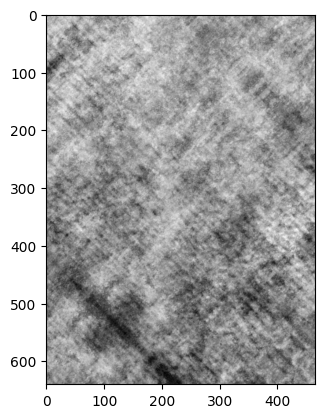

In [ ]:
# rotated_image = rotate(test_img, angle=45, mode='reflect', resize = False)
# rotated_image = np.round(rotated_image * 255).clip(0, 255).astype(np.uint8)
# plt.imshow(rotated_image, cmap='gray')

In [54]:
rotation_angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

# counters for each angle
correct_classification_counts = {angle: 0 for angle in rotation_angles}
total_images = 0

print('___________________________\n')
for test_subdir in test_dirs:
  actual_class = os.path.basename(test_subdir)
  print(f"Started processing test sub-directory: {actual_class}")

  img_paths = sorted(glob.glob(os.path.join(test_subdir, '*.png')))
  print(f"Total test images found for sub-directory - {actual_class}: {len(img_paths)}\n")

  # process each image
  for img_path in img_paths:
    # print(f"Processing test image: {os.path.basename(img_path)}")
    img = skimage.io.imread(img_path).astype(np.float32) / 255.0
    img = skimage.color.rgb2gray(img)
    img = np.round(img * 255).clip(0, 255).astype(np.uint8)

    for angle in rotation_angles:
      if angle == 0:
        rotated_img = img
      else:
        rotated_img = skimage.transform.rotate(img, angle=angle, resize=False, mode='reflect')
        rotated_img = np.round(rotated_img * 255).clip(0, 255).astype(np.uint8)

      lbp_map = get_lbp_map_for_img_vectorized(rotated_img)
      lbp_hist = calculate_lbp_histogram_from_lbp_map(lbp_map)
      predicted_class_label = predict_class_lable_for_lbp_hist(lbp_hist)

      if predicted_class_label == actual_class:
        correct_classification_counts[angle] += 1

    total_images += 1
  print(f"\nProcessed {total_images} images.")
  print(f"\nFinished processing class: {actual_class}")
  print('___________________________\n')

___________________________

Started processing test sub-directory: gauzy
Total test images found for sub-directory - gauzy: 40


Processed 40 images.

Finished processing class: gauzy
___________________________

Started processing test sub-directory: meshed
Total test images found for sub-directory - meshed: 40


Processed 80 images.

Finished processing class: meshed
___________________________

Started processing test sub-directory: cracked
Total test images found for sub-directory - cracked: 40


Processed 120 images.

Finished processing class: cracked
___________________________

Started processing test sub-directory: stratified
Total test images found for sub-directory - stratified: 40


Processed 160 images.

Finished processing class: stratified
___________________________

Started processing test sub-directory: scaly
Total test images found for sub-directory - scaly: 40


Processed 200 images.

Finished processing class: scaly
___________________________

Started processing 

In [55]:
angle_accuracies = {}
for angle in rotation_angles:
    accuracy = (correct_classification_counts[angle] / total_images) * 100
    angle_accuracies[angle] = accuracy
    print(f"Classification accuracy at angle {angle}: {round(accuracy, 2)}%")

Classification accuracy at angle 0: 13.3%
Classification accuracy at angle 15: 9.47%
Classification accuracy at angle 30: 8.09%
Classification accuracy at angle 45: 6.7%
Classification accuracy at angle 60: 5.96%
Classification accuracy at angle 75: 6.33%
Classification accuracy at angle 90: 7.87%
Classification accuracy at angle 105: 6.49%
Classification accuracy at angle 120: 6.76%
Classification accuracy at angle 135: 7.02%
Classification accuracy at angle 150: 7.5%
Classification accuracy at angle 165: 9.26%
Classification accuracy at angle 180: 11.6%


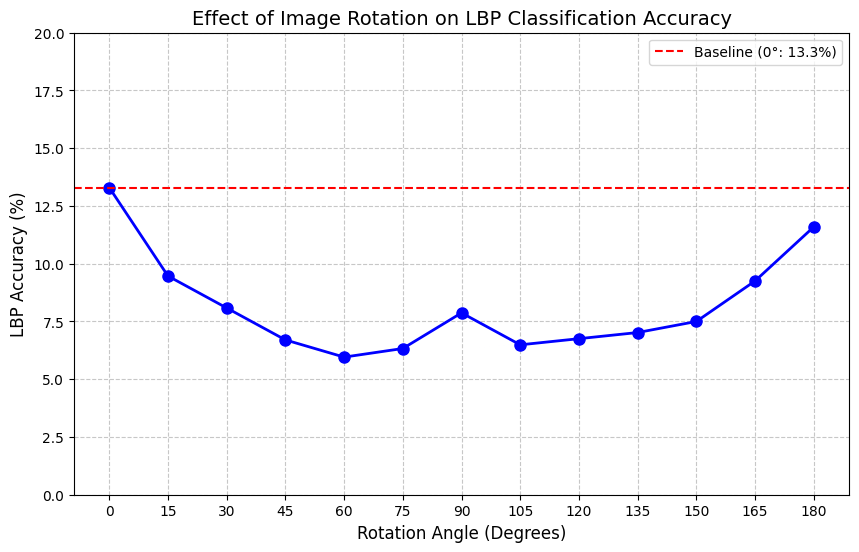

In [56]:
angles = sorted(angle_accuracies.keys())
accuracies = [angle_accuracies[a] for a in angles]

plt.figure(figsize=(10, 6))
plt.plot(angles, accuracies, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

plt.title('Effect of Image Rotation on LBP Classification Accuracy', fontsize=14)
plt.xlabel('Rotation Angle (Degrees)', fontsize=12)
plt.ylabel('LBP Accuracy (%)', fontsize=12)
plt.xticks(angles)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 20)

plt.axhline(y=accuracies[0], color='r', linestyle='--', label=f'Baseline (0°: {accuracies[0]:.1f}%)')
plt.legend()

plt.show()

#### Q1(c): Rotation Invariant LBP

In [60]:
# gives the ookup Table for 8-bit rotation invariant uniform LBP
def get_riu2_lut():
    # gives the ookup Table for 8-bit rotation invariant uniform LBP
    lut = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        # Convert to 8-bit binary string
        bit_str = format(i, '08b')
        bits = np.array([int(b) for b in bit_str])
        
        # Calculate the uniformity measure U
        # Count transitions: (b7-b0) + sum(|b_i - b_{i-1}|)
        transitions = np.abs(bits[0] - bits[-1]) + np.sum(np.abs(bits[1:] - bits[:-1]))
        
        if transitions <= 2:
            # If uniform then the code is the number of 1s
            lut[i] = np.sum(bits)
        else:
            # If it is non-uniform then assign it to the 9th bin
            lut[i] = 9
    return lut

RIU2_LUT = get_riu2_lut()

# Compute the rotation-invariant uniform LBP map
def get_lbp_riu2_map_vectorized(img):
    standard_lbp_map = get_lbp_map_for_img_vectorized(img)
    # Map the standard codes to riu2 codes using the LUT
    riu2_map = RIU2_LUT[standard_lbp_map]
    return riu2_map

# Compute the 10-bin normalized histogram for riu2 LBP
def calculate_lbp_riu2_histogram(lbp_map):
    # Bins: 0-8 (uniform) and 9 (non-uniform)
    hist, _ = np.histogram(lbp_map.flatten(), bins=np.arange(11), density=True)
    return hist

In [61]:
x_train_riu2 = [] # will contain the histograms
y_train = [] # will contain the classes


train_dirs = [x for x in Path(train_path).iterdir()]
print(f"Total sub-directories found in train directory: {len(train_dirs)}")
print('___________________________\n')

# Traverse each sub-directory (class)
total_images = 0
for train_subdir in train_dirs:
  class_name = os.path.basename(train_subdir)
  print(f"Started processing class: {class_name}")

  # Get all image paths for that class
  img_paths = sorted(glob.glob(os.path.join(train_subdir, '*.png')))
  print(f"Total images found for class - {class_name}: {len(img_paths)}\n")

  # process each image
  for img_path in img_paths:
    print(f"Processing image: {os.path.basename(img_path)}")
    img = skimage.io.imread(img_path).astype(np.float32) / 255.0
    img = skimage.color.rgb2gray(img)
    img = np.round(img * 255).clip(0, 255).astype(np.uint8)

    lbp_map = get_lbp_riu2_map_vectorized(img)
    lbp_hist = calculate_lbp_riu2_histogram(lbp_map)
    x_train_riu2.append(lbp_hist)
    y_train.append(class_name)
    total_images += 1

  print(f"\nFinished processing class: {class_name}")
  print('___________________________\n')


print(f"Total images processed in train directory: {total_images}")

x_train_riu2_matrix = np.vstack(x_train_riu2)
y_train_np = np.array(y_train)

Total sub-directories found in train directory: 48
___________________________

Started processing class: gauzy
Total images found for class - gauzy: 40

Processing image: 00600.png
Processing image: 00601.png
Processing image: 00602.png
Processing image: 00603.png
Processing image: 00604.png
Processing image: 00605.png
Processing image: 00606.png
Processing image: 00607.png
Processing image: 00608.png
Processing image: 00609.png
Processing image: 00610.png
Processing image: 00611.png
Processing image: 00612.png
Processing image: 00613.png
Processing image: 00614.png
Processing image: 00615.png
Processing image: 00616.png
Processing image: 00617.png
Processing image: 00618.png
Processing image: 00619.png
Processing image: 00620.png
Processing image: 00621.png
Processing image: 00622.png
Processing image: 00623.png
Processing image: 00624.png
Processing image: 00625.png
Processing image: 00626.png
Processing image: 00627.png
Processing image: 00628.png
Processing image: 00629.png
Proces

In [62]:
def predict_class_lable_riu2(test_lbp_hist):
  squared_sum = np.sum(np.square(x_train_riu2_matrix - test_lbp_hist), axis=1)
  predicted_label = y_train_np[np.argmin(squared_sum)]
  return predicted_label

In [63]:
rotation_angles = [0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]

# counters for each angle
correct_classification_counts_riu2 = {angle: 0 for angle in rotation_angles}
total_images = 0

print('___________________________\n')
for test_subdir in test_dirs:
  actual_class = os.path.basename(test_subdir)
  print(f"Started processing test sub-directory: {actual_class}")

  img_paths = sorted(glob.glob(os.path.join(test_subdir, '*.png')))
  print(f"Total test images found for sub-directory - {actual_class}: {len(img_paths)}\n")

  # process each image
  for img_path in img_paths:
    # print(f"Processing test image: {os.path.basename(img_path)}")
    img = skimage.io.imread(img_path).astype(np.float32) / 255.0
    img = skimage.color.rgb2gray(img)
    img = np.round(img * 255).clip(0, 255).astype(np.uint8)

    for angle in rotation_angles:
      if angle == 0:
        rotated_img = img
      else:
        rotated_img = skimage.transform.rotate(img, angle=angle, resize=False, mode='reflect')
        rotated_img = np.round(rotated_img * 255).clip(0, 255).astype(np.uint8)

      lbp_map = get_lbp_riu2_map_vectorized(rotated_img)
      lbp_hist = calculate_lbp_riu2_histogram(lbp_map)
      predicted_class_label = predict_class_lable_riu2(lbp_hist)

      if predicted_class_label == actual_class:
        correct_classification_counts_riu2[angle] += 1

    total_images += 1
  print(f"\nProcessed {total_images} images.")
  print(f"\nFinished processing class: {actual_class}")
  print('___________________________\n')

___________________________

Started processing test sub-directory: gauzy
Total test images found for sub-directory - gauzy: 40


Processed 40 images.

Finished processing class: gauzy
___________________________

Started processing test sub-directory: meshed
Total test images found for sub-directory - meshed: 40


Processed 80 images.

Finished processing class: meshed
___________________________

Started processing test sub-directory: cracked
Total test images found for sub-directory - cracked: 40


Processed 120 images.

Finished processing class: cracked
___________________________

Started processing test sub-directory: stratified
Total test images found for sub-directory - stratified: 40


Processed 160 images.

Finished processing class: stratified
___________________________

Started processing test sub-directory: scaly
Total test images found for sub-directory - scaly: 40


Processed 200 images.

Finished processing class: scaly
___________________________

Started processing 

In [65]:
angle_accuracies_riu = {}
for angle in rotation_angles:
    accuracy = (correct_classification_counts_riu2[angle] / total_images) * 100
    angle_accuracies_riu[angle] = accuracy
    print(f"Classification accuracy at angle {angle}: {round(accuracy, 2)}%")

Classification accuracy at angle 0: 9.79%
Classification accuracy at angle 15: 6.38%
Classification accuracy at angle 30: 6.01%
Classification accuracy at angle 45: 6.65%
Classification accuracy at angle 60: 6.06%
Classification accuracy at angle 75: 7.23%
Classification accuracy at angle 90: 8.94%
Classification accuracy at angle 105: 7.18%
Classification accuracy at angle 120: 6.65%
Classification accuracy at angle 135: 6.7%
Classification accuracy at angle 150: 6.12%
Classification accuracy at angle 165: 7.45%
Classification accuracy at angle 180: 9.79%


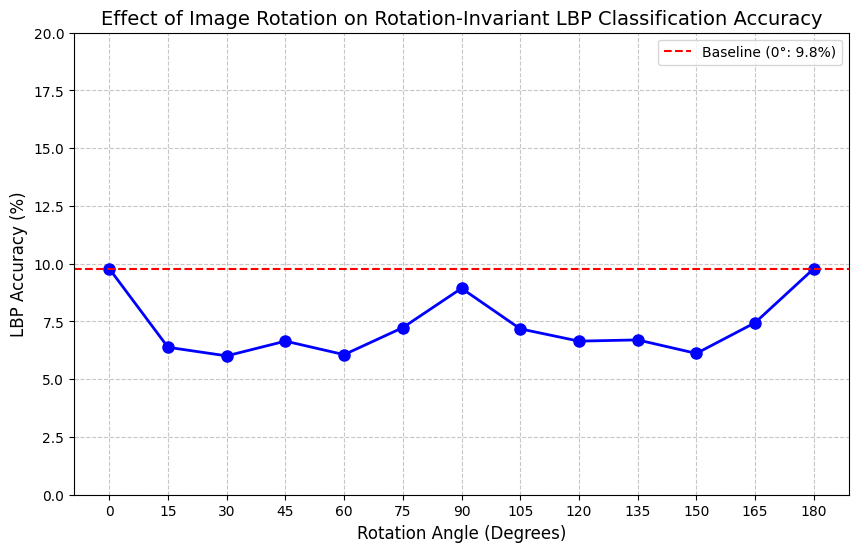

In [66]:
angles = sorted(angle_accuracies_riu.keys())
accuracies = [angle_accuracies_riu[a] for a in angles]

plt.figure(figsize=(10, 6))
plt.plot(angles, accuracies, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

plt.title('Effect of Image Rotation on Rotation-Invariant LBP Classification Accuracy', fontsize=14)
plt.xlabel('Rotation Angle (Degrees)', fontsize=12)
plt.ylabel('LBP Accuracy (%)', fontsize=12)
plt.xticks(angles)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 20)

plt.axhline(y=accuracies[0], color='r', linestyle='--', label=f'Baseline (0°: {accuracies[0]:.1f}%)')
plt.legend()

plt.show()

#### Comparison of Standard vs Rotation Invariant LBP

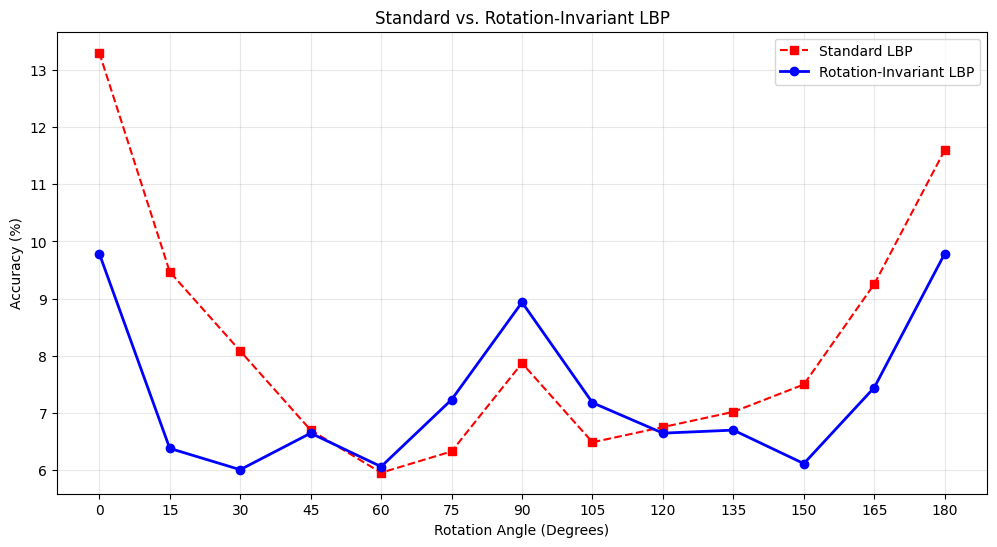

In [71]:
# accuracies for both methods
rotation_angles = sorted(correct_classification_counts.keys())

standard_accs = [ (correct_classification_counts[a] / total_images) * 100 for a in rotation_angles]
riu2_accs = [ (correct_classification_counts_riu2[a] / total_images) * 100 for a in rotation_angles]


plt.figure(figsize=(12, 6))
plt.plot(rotation_angles, standard_accs, 'r--s', label='Standard LBP')
plt.plot(rotation_angles, riu2_accs, 'b-o', label='Rotation-Invariant LBP', linewidth=2)

plt.title('Standard vs. Rotation-Invariant LBP')
plt.xlabel('Rotation Angle (Degrees)')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation_angles)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()